<a href="https://colab.research.google.com/github/xDaryamo/NFR-Security-Extraction-Classification/blob/master/NFR_Classification_Categorization_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) Dipendenze e utils


##0.1 Dipendenze

In [1]:
!python -m spacy download en_core_web_trf --quiet
!pip install spacy-transformers --quiet

2022-11-28 17:31:51.090722: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 460.3 MB 24 kB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 4.7 MB 16.1 MB/s 
     |████████████████████████████████| 1.1 MB 75.7 MB/s 
     |████████████████████████████████| 6.6 MB 46.2 MB/s 
     |████████████████████████████████| 182 kB 60.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
!pip install tokenizers --quiet
!pip install transformers --quiet
!pip install pytorch-transformers --quiet

     |████████████████████████████████| 176 kB 8.8 MB/s 
     |████████████████████████████████| 880 kB 45.1 MB/s 
     |████████████████████████████████| 132 kB 44.7 MB/s 
     |████████████████████████████████| 1.3 MB 40.0 MB/s 
     |████████████████████████████████| 79 kB 4.2 MB/s 
     |████████████████████████████████| 10.0 MB 40.8 MB/s 
     |████████████████████████████████| 140 kB 12.6 MB/s 
     |████████████████████████████████| 127 kB 24.6 MB/s 


In [3]:
!pip install scikit-plot --quiet
!pip install scikit-multilearn --quiet

     |████████████████████████████████| 89 kB 4.0 MB/s 


In [4]:
import pandas as pd
import spacy
from spacy import displacy
from tabulate import tabulate
from string import punctuation
import re
from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel
import spacy_transformers
import numpy as np
from numpy import mean
import ast
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, plot_confusion_matrix, balanced_accuracy_score, hamming_loss, f1_score, multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold, KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import MultiLabelBinarizer
import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
import warnings



In [5]:
nlp = spacy.load("en_core_web_trf")

##0.2) Funzioni utili

In [6]:
all_entities = list(nlp.get_pipe("ner").labels)
all_pos = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
all_dep = list(nlp.get_pipe("parser").labels)

In [7]:
def str_to_list(ent, dep, pos):
  ent = ast.literal_eval(ent)
  ent = [n.strip() for n in ent]
  dep = ast.literal_eval(dep)
  dep = [n.strip() for n in dep]
  pos = ast.literal_eval(pos)
  pos = [n.strip() for n in pos]

  return ent, dep, pos

In [8]:
def conc_3_lists(a,b,c):
  temp = np.concatenate((a, b), axis=0)
  result = np.concatenate((temp, c), axis=0)
  return " ".join(result.tolist())


In [9]:
# pick the model type

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased")

# new tokens
new_tokens = conc_3_lists(all_entities, all_dep, all_pos).split(" ")

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# add the tokens to the tokenizer vocabulary
tokenizer.add_tokens(list(new_tokens))

# add new, random embeddings for the new tokens
model.resize_token_embeddings(len(tokenizer))

def encode_all(df):
  all_tokens = []

  for i in range(0, len(df)):
      ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
      item = conc_3_lists(ent,dep,pos)
      all_tokens.append(item)

  return tokenizer(all_tokens, padding=True)['input_ids']



def encode_feature(feature):
  input_ids = tokenizer.convert_tokens_to_ids(feature)
  final_ids = tokenizer.prepare_for_model(input_ids)

  return final_ids['input_ids']

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#1) Classificatore Binario

## 1.1) Ottenimento del Dataset

In [10]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")

df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)


,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


###1.1.1) Esempio codifica delle features (entities, dependencies e parts of speech)

In [11]:
#esempio di encoding dei token
ent, dep, pos = str_to_list(df["Entities"][5], df["Dependencies"][5], df["Parts of Speech"][5])
ent2, dep2, pos2 = str_to_list(df["Entities"][0], df["Dependencies"][0], df["Parts of Speech"][0])
list1 = conc_3_lists(ent, dep, pos)
list2 = conc_3_lists(ent2, dep2, pos2)
print(list1)
print(list2)
batch_sentences = [list1, list2]
#print(batch_sentences)
encoded_inputs = tokenizer(batch_sentences, padding=True)['input_ids']
print(encoded_inputs)
#decoded_inputs = tokenizer.batch_decode(encoded_inputs)
#print(decoded_inputs)

It was acknowledged that the ORG needs to enable appropriate and efficient patient information flows between the ORG and other information and communication point of service systems nsubjpass auxpass ROOT mark det nsubj ccomp aux xcomp amod cc conj compound compound dobj prep det pobj cc amod nmod cc conj nmod prep pobj conj PRON AUX VERB SCONJ DET PROPN VERB PART VERB ADJ CCONJ ADJ NOUN NOUN NOUN ADP DET PROPN CCONJ ADJ NOUN CCONJ NOUN NOUN ADP NOUN NOUN
The vision of healthier NORP through innovative e health solutions is supported by an infostructure that provides residents of GPE and their health care providers with timely appropriate and secure access to the right information when and where they enter into the health care system det nsubjpass prep amod pobj prep amod compound compound pobj auxpass ROOT agent det pobj nsubj relcl dobj prep pobj cc poss compound compound conj prep amod conj cc conj pobj prep det amod pobj advmod cc conj nsubj relcl prep det compound compound pobj DE

In [12]:
#esempio di encoding dei token
ent, dep, pos = df["Entities"][5], df["Dependencies"][5], df["Parts of Speech"][0]
ent, dep, pos = str_to_list(ent, dep, pos)

list_ent = encode_feature(ent)
print(list_ent)


[101, 1135, 1108, 8646, 1115, 1103, 28998, 2993, 1106, 9396, 5806, 1105, 7856, 5351, 1869, 5611, 1206, 1103, 28998, 1105, 1168, 1869, 1105, 4909, 1553, 1104, 1555, 2344, 102]


##1.2) Codifica delle features

In [13]:
all_ids = encode_all(df)

sec_df=pd.DataFrame(columns=["enc_ent", "enc_dep", "enc_pos", "enc_all", "Security Words", "Security"])

for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  sec_df.loc[i, "enc_ent"] = encode_feature(ent)
  sec_df.loc[i, "enc_dep"] = encode_feature(dep)
  sec_df.loc[i, "enc_pos"] = encode_feature(pos)
  sec_df.loc[i, "enc_all"] = all_ids[i]
  sec_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  sec_df.loc[i, "Security"] = df.iloc[i]["Security"]

sec_df.head()

,enc_ent,enc_dep,enc_pos,enc_all,Security Words,Security
0,"[101, 1109, 4152, 1104, 100, 29048, 1194, 1003...","[101, 29023, 29068, 29012, 29034, 29031, 29012...","[101, 29005, 29058, 29030, 29064, 28999, 29030...","[101, 1109, 4152, 1104, 2332, 2852, 29048, 119...",['access'],1
1,"[101, 2857, 2063, 1103, 4828, 2332, 1647, 100,...","[101, 29025, 29027, 29023, 29034, 7090, 29014,...","[101, 29018, 29047, 29005, 29064, 29058, 29058...","[101, 2857, 2063, 1103, 4828, 2332, 1647, 142,...",none,0
2,"[101, 28998, 28998, 28998, 28998, 28998, 100, ...","[101, 7090, 7090, 29021, 1692, 29021, 1692, 70...","[101, 28999, 28999, 28999, 29032, 28999, 29032...","[101, 28998, 28998, 28998, 28998, 28998, 112, ...",none,0
3,"[101, 100, 2469, 1106, 1869, 1209, 1494, 12862...","[101, 29034, 29014, 29012, 29031, 24544, 29063...","[101, 29064, 29058, 29030, 29058, 29019, 29047...","[101, 2614, 1193, 2469, 1106, 1869, 1209, 1494...",['access'],1
4,"[101, 1249, 1226, 1104, 1103, 28998, 170, 2904...","[101, 29012, 29031, 29012, 29023, 29031, 29023...","[101, 29030, 29058, 29030, 29005, 28999, 29005...","[101, 1249, 1226, 1104, 1103, 28998, 170, 2904...",none,0


##1.3) Tuning degli iperparametri


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')
warnings.filterwarnings("ignore")

###1.3.1) Tuning RandomForest

In [15]:
rf = RandomForestClassifier() 

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


rf_grid = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap
          }

rf_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
rf_model.fit(X, y)

rf_best = rf_model.best_params_
print('Config: %s' % rf_best)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'n_estimators': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


###1.3.2) Tuning LogisticRegression

In [16]:
lr = LogisticRegression()

lr_grid = [
            {
              'solver' : ['saga'],
              'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
              'max_iter' : [100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {
              'solver' : ['newton-cg', 'lbfgs'],
              'penalty' : ['l2','none'],
              'max_iter' :[100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
          ]

lr_model = RandomizedSearchCV(estimator = lr, param_distributions=lr_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
lr_model.fit(X, y)

lr_best = lr_model.best_params_
print('Config: %s' % lr_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 100}


###1.3.3) Tuning SVM

In [17]:
svm = SVC()

svm_grid =  {
              'C': [0.1,1, 10, 100, 1000], 
              'gamma': [1,0.1,0.01,0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']
            }

svm_model = RandomizedSearchCV(estimator = svm, param_distributions=svm_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
svm_model.fit(X, y)

svm_best = svm_model.best_params_
print('Config: %s' % svm_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}


###1.3.4) Tuning GaussianNB

In [18]:
gNB = GaussianNB()

nb_grid = {
            'var_smoothing': np.logspace(0,-9, num=100)
          }       

nb_model = RandomizedSearchCV(estimator = gNB, param_distributions=nb_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
nb_model.fit(X, y)

nb_best = nb_model.best_params_
print('Config: %s' % nb_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'var_smoothing': 1.0}


###1.3.5) Tuning KNN

In [19]:
knn = KNeighborsClassifier(algorithm='auto')


knn_grid =  {
              'n_neighbors': (1,10, 1),
              'leaf_size': (20,40,1),
              'p': (1,2),
              'weights': ('uniform', 'distance'),
              'metric': ('minkowski', 'chebyshev'),
            }       

knn_model = RandomizedSearchCV(estimator = knn, param_distributions=knn_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
knn_model.fit(X, y)

knn_best = knn_model.best_params_
print('Config: %s' % knn_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'leaf_size': 40}


###1.3.6) Tuning DecisionTree

In [20]:
dt = DecisionTreeClassifier()


dt_grid = {
            'max_features': ['auto', 'sqrt', 'log2'],
            'ccp_alpha': [0.1, .01, .001],
            'max_depth' : [5, 6, 7, 8, 9],
            'criterion' :['gini', 'entropy']
          }    

dt_model = RandomizedSearchCV(estimator = dt, param_distributions=dt_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
dt_model.fit(X, y)

dt_best = dt_model.best_params_
print('Config: %s' % dt_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini', 'ccp_alpha': 0.001}


##1.4) Validazione modelli con Cross-Fold Validation

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')


###1.4.1) Logistic regression

fit_time:  4.461597537994384
Accuracy:  0.6936454849498327
F1_macro:  0.6936454849498327
Precision_micro:  0.6936454849498327
Recall_micro:  0.6936454849498327


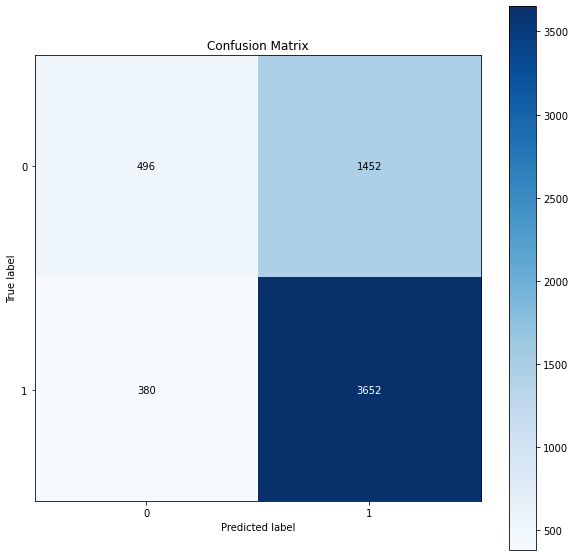

In [23]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

lr = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(lr_scores['fit_time']))
print("Accuracy: ",np.mean(lr_scores['test_accuracy']))
print("F1_macro: ",np.mean(lr_scores['test_f1']))
print("Precision_micro: ",np.mean(lr_scores['test_precision']))
print("Recall_micro: ",np.mean(lr_scores['test_recall']))

predictions = cross_val_predict(lr, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.2) RandomForest

fit_time:  0.6209337711334229
Accuracy:  0.732943143812709
F1_macro:  0.732943143812709
Precision_micro:  0.732943143812709
Recall_micro:  0.732943143812709


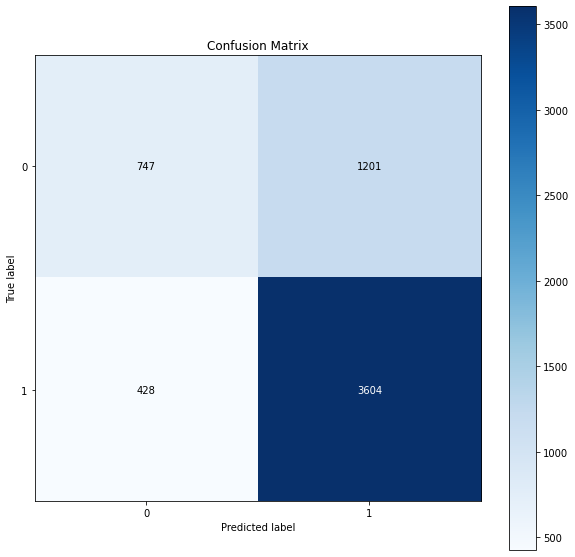

In [22]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

rf = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

rf_scores = cross_validate(rf, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(rf_scores['fit_time']))
print("Accuracy: ",np.mean(rf_scores['test_accuracy']))
print("F1_macro: ",np.mean(rf_scores['test_f1']))
print("Precision_micro: ",np.mean(rf_scores['test_precision']))
print("Recall_micro: ",np.mean(rf_scores['test_recall']))

predictions = cross_val_predict(rf, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.3) Gaussian Naive Bayes

fit_time:  0.13959922790527343
Accuracy:  0.5908026755852843
F1_micro:  0.5908026755852843
Precision_micro:  0.5908026755852843
Recall_micro:  0.5908026755852843


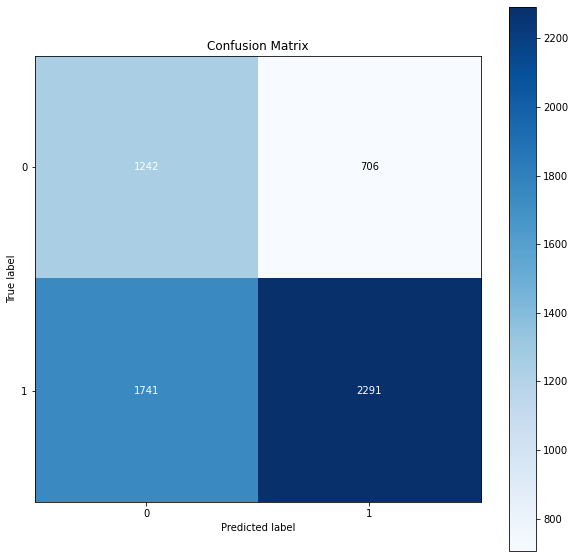

In [25]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

gNB = GaussianNB(var_smoothing=1.0)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
gb_scores = cross_validate(gNB, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(gb_scores['fit_time']))
print("Accuracy: ",np.mean(gb_scores['test_accuracy']))
print("F1_micro: ",np.mean(gb_scores['test_f1']))
print("Precision_micro: ",np.mean(gb_scores['test_precision']))
print("Recall_micro: ",np.mean(gb_scores['test_recall']))

predictions = cross_val_predict(gNB, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.4) Support Vector Machine

fit_time:  6.691083812713623
Accuracy:  0.6790969899665552
F1_micro:  0.6790969899665552
Precision_micro:  0.6790969899665552
Recall_micro:  0.6790969899665552


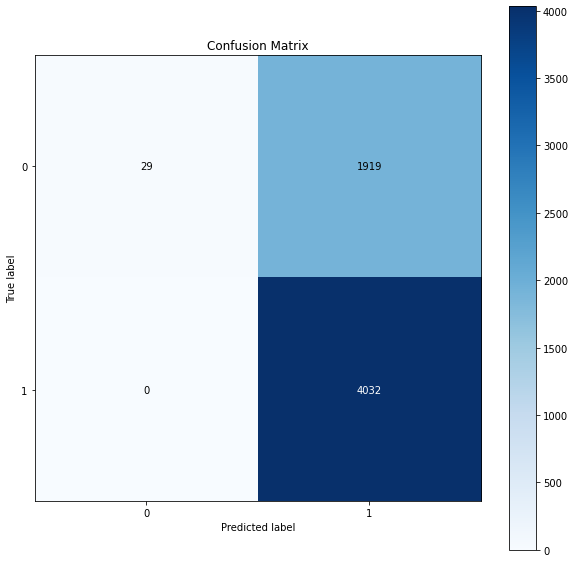

In [24]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

svm = SVC(kernel='rbf', gamma=0.0001, C=10)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
svm_scores = cross_validate(svm, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(svm_scores['fit_time']))
print("Accuracy: ",np.mean(svm_scores['test_accuracy']))
print("F1_micro: ",np.mean(svm_scores['test_f1']))
print("Precision_micro: ",np.mean(svm_scores['test_precision']))
print("Recall_micro: ",np.mean(svm_scores['test_recall']))

predictions = cross_val_predict(svm, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.5) k-Nearest Neighbors

fit_time:  0.11221909523010254
Accuracy:  0.7075250836120401
F1_micro:  0.7075250836120401
Precision_micro:  0.7075250836120401
Recall_micro:  0.7075250836120401


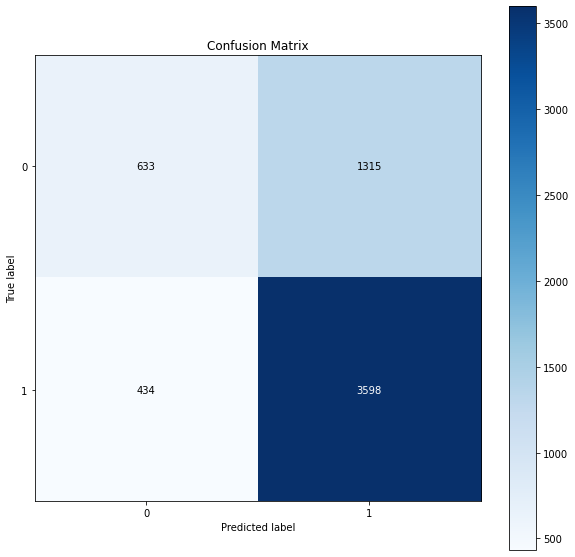

In [26]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

knn = KNeighborsClassifier(algorithm='auto',weights='distance',p=1,n_neighbors=10, metric='minkowski', leaf_size=40)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
knn_scores = cross_validate(knn, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(knn_scores['fit_time']))
print("Accuracy: ",np.mean(knn_scores['test_accuracy']))
print("F1_micro: ",np.mean(knn_scores['test_f1']))
print("Precision_micro: ",np.mean(knn_scores['test_precision']))
print("Recall_micro: ",np.mean(knn_scores['test_recall']))

predictions = cross_val_predict(knn, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.6) Decision Tree

fit_time:  0.09931154251098633
Accuracy:  0.7051839464882943
F1_micro:  0.7051839464882943
Precision_micro:  0.7051839464882943
Recall_micro:  0.7051839464882943


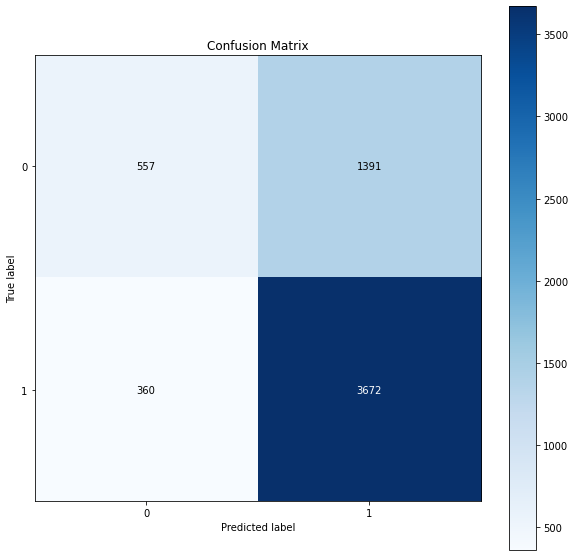

In [27]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

dt = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(dt_scores['fit_time']))
print("Accuracy: ",np.mean(dt_scores['test_accuracy']))
print("F1_micro: ",np.mean(dt_scores['test_f1']))
print("Precision_micro: ",np.mean(dt_scores['test_precision']))
print("Recall_micro: ",np.mean(dt_scores['test_recall']))

predictions = cross_val_predict(dt, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


#2) Classificatore Multi-label

##2.1) Ottenimento del Dataset

In [28]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")
df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)

,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


In [29]:
#Per allenare il modello che si occupa di categorizzare i requisiti dobbiamo eliminare tutte le righe che non contengono un requisito di sicurezza (non hanno categorie associate)

df.drop(df[df.Security == 0.0].index, inplace=True)
df = df.reset_index()  # make sure indexes pair with number of rows
df.head()

,index,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
2,5,It was acknowledged that the EHR needs to enab...,"['It', 'was', 'acknowledged', 'that', 'the', '...","['nsubjpass', 'auxpass', 'ROOT', 'mark', 'det'...","['PRON', 'AUX', 'VERB', 'SCONJ', 'DET', 'PROPN...",['CONFIDENTIALITY'],none,1
3,14,Nursing data: Should be structured and codifie...,"['Nursing', 'data', 'Should', 'be', 'structure...","['compound', 'nsubjpass', 'aux', 'auxpass', 'R...","['NOUN', 'NOUN', 'AUX', 'AUX', 'VERB', 'CCONJ'...",['INTEGRITY'],none,1
4,17,Nursing data: Should be simple and concise to ...,"['Nursing', 'data', 'Should', 'be', 'simple', ...","['compound', 'nsubj', 'aux', 'ROOT', 'acomp', ...","['NOUN', 'NOUN', 'AUX', 'AUX', 'ADJ', 'CCONJ',...",['AVAILABILITY'],['access'],1


##2.2) Codifica delle features

In [30]:
all_ids = encode_all(df)

cat_df=pd.DataFrame(columns=["enc_ent", "enc_dep", "enc_pos", "enc_all", "Security Words", "Categories"])



for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  cat_df.loc[i, "enc_ent"] = encode_feature(ent)
  cat_df.loc[i, "enc_dep"] = encode_feature(dep)
  cat_df.loc[i, "enc_pos"] = encode_feature(pos)
  cat_df.loc[i, "enc_all"] = all_ids[i]
  cat_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  cat_df.loc[i, "Categories"] = df.iloc[i]["Categories"]

cat_df.head()

,enc_ent,enc_dep,enc_pos,enc_all,Security Words,Categories
0,"[101, 1109, 4152, 1104, 100, 29048, 1194, 1003...","[101, 29023, 29068, 29012, 29034, 29031, 29012...","[101, 29005, 29058, 29030, 29064, 28999, 29030...","[101, 1109, 4152, 1104, 2332, 2852, 29048, 119...",['access'],"['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']"
1,"[101, 100, 2469, 1106, 1869, 1209, 1494, 12862...","[101, 29034, 29014, 29012, 29031, 24544, 29063...","[101, 29064, 29058, 29030, 29058, 29019, 29047...","[101, 2614, 1193, 2469, 1106, 1869, 1209, 1494...",['access'],['AVAILABILITY']
2,"[101, 1135, 1108, 8646, 1115, 1103, 28998, 299...","[101, 29068, 28996, 29063, 4551, 29023, 29014,...","[101, 29051, 29019, 29047, 29050, 29005, 28999...","[101, 1135, 1108, 8646, 1115, 1103, 28998, 299...",none,['CONFIDENTIALITY']
3,"[101, 15192, 2233, 9743, 1129, 15695, 1105, 10...","[101, 7090, 29068, 24544, 28996, 29063, 14402,...","[101, 29058, 29058, 29019, 29019, 29047, 29013...","[101, 15192, 2233, 9743, 1129, 15695, 1105, 18...",none,['INTEGRITY']
4,"[101, 15192, 2233, 9743, 1129, 3014, 1105, 100...","[101, 7090, 29014, 24544, 29063, 29016, 14402,...","[101, 29058, 29058, 29019, 29019, 29064, 29013...","[101, 15192, 2233, 9743, 1129, 3014, 1105, 142...",['access'],['AVAILABILITY']


##2.3) One-hot encoding delle categorie

In [31]:
#convertiamo le categorie in liste
cat_df['Categories'] = cat_df['Categories'].apply(lambda x: ast.literal_eval(x))


In [32]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(cat_df['Categories'])
pd.DataFrame(y, columns=multilabel.classes_)

,ACCESS_CONTROL_IDENTITY,ACCOUNTABILITY,AVAILABILITY,CONFIDENTIALITY,INTEGRITY,OPERATIONAL,PRIVACY
0,0,0,1,1,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
4027,1,0,0,0,0,0,0
4028,0,1,1,1,0,0,0
4029,0,0,0,0,1,0,0
4030,0,0,0,0,1,0,0


In [33]:
from itertools import groupby
from IPython.display import display, HTML
display(HTML(cat_df.Categories.apply(tuple).value_counts().to_frame().to_html()))

,Categories
"(CONFIDENTIALITY, ACCOUNTABILITY, INTEGRITY)",1599
"(ACCOUNTABILITY, INTEGRITY)",421
"(CONFIDENTIALITY, ACCOUNTABILITY)",331
"(CONFIDENTIALITY,)",191
"(INTEGRITY, ACCOUNTABILITY)",140
"(CONFIDENTIALITY, INTEGRITY, ACCOUNTABILITY)",135
"(OPERATIONAL,)",121
"(INTEGRITY,)",120
"(ACCOUNTABILITY,)",120
"(ACCOUNTABILITY, CONFIDENTIALITY)",82


##2.4) Creazione modelli

In [34]:
def hamming_score(y_true, y_pred):
    return (
        (y_true & y_pred.toarray()).sum(axis=1) / (y_true | y_pred.toarray()).sum(axis=1)
    ).mean()

In [35]:
def plot_confusion_matrix(cm):
  f, axes = plt.subplots(2, 4, figsize=(25, 15))
  axes = axes.ravel()
  for i in range(7):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g',cmap='Blues')
    disp.ax_.set_title(list(multilabel.classes_)[i])
    disp.im_.colorbar.remove()

  f.delaxes(axes[7])
  plt.subplots_adjust(wspace=0.25, hspace=0.10)
  f.colorbar(disp.im_, ax=axes)
  plt.show()


In [36]:
def build_model(model, mlb_estimator, X, y):

  clf=mlb_estimator(model)
  kf = KFold(n_splits=5, shuffle=True)

  acc_scores = np.zeros(5)
  prec_scores = np.zeros(5)
  rec_scores = np.zeros(5)  
  f_scores = np.zeros(5)
  ham_scores = np.zeros(5)
  conf_matrix = []
  idx = 0

  for index, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    print("Training on fold " + str(index+1) + "/5...")
    # Generate batches from indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    clf.fit(X_train.to_list(), y_train)
    clf_pred = clf.predict(X_test.to_list())

    conf_matrix.append(multilabel_confusion_matrix(y_test, clf_pred ))
    acc_scores[idx] = hamming_score(y_test, clf_pred)
    prec_scores[idx] = precision_score(y_test, clf_pred, average='micro')
    rec_scores[idx] = recall_score(y_test, clf_pred, average='micro')
    f_scores[idx] = f1_score(y_test, clf_pred, average='micro')
    ham_scores[idx] = hamming_loss(y_test, clf_pred)
    idx+=1
  return acc_scores, prec_scores, rec_scores, f_scores, ham_scores, conf_matrix

In [37]:
X = cat_df["enc_all"]

###**2.4.1) BinaryRelevance**

####2.4.1.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6902141108149024
Precision: 0.7554515751655181
Recall Score: 0.850847183005134
F1 Score: 0.8003021113129117
Hamming Loss: 0.14512623723560286


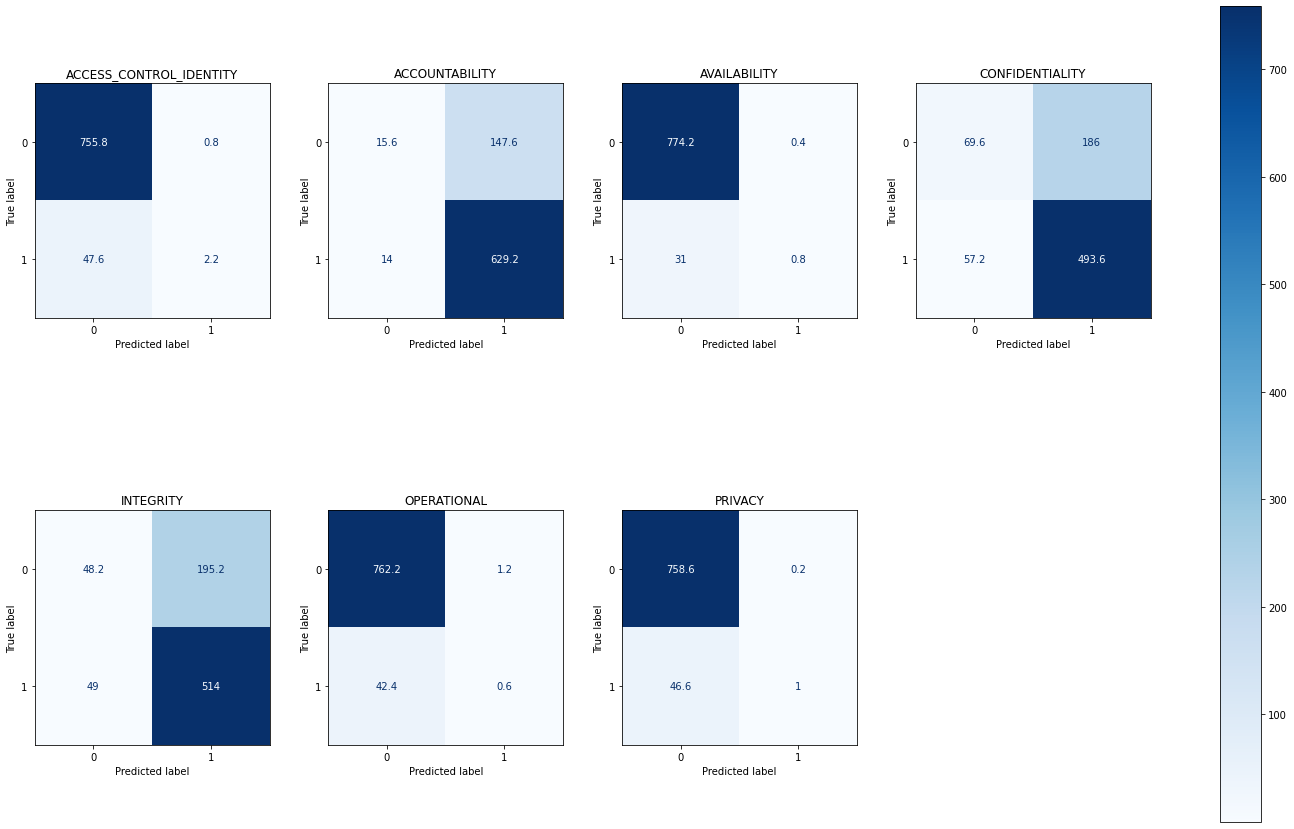

In [38]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6818274598913764
Precision: 0.7312477269566198
Recall Score: 0.8676224156884305
F1 Score: 0.7936131296829124
Hamming Loss: 0.154231342467342


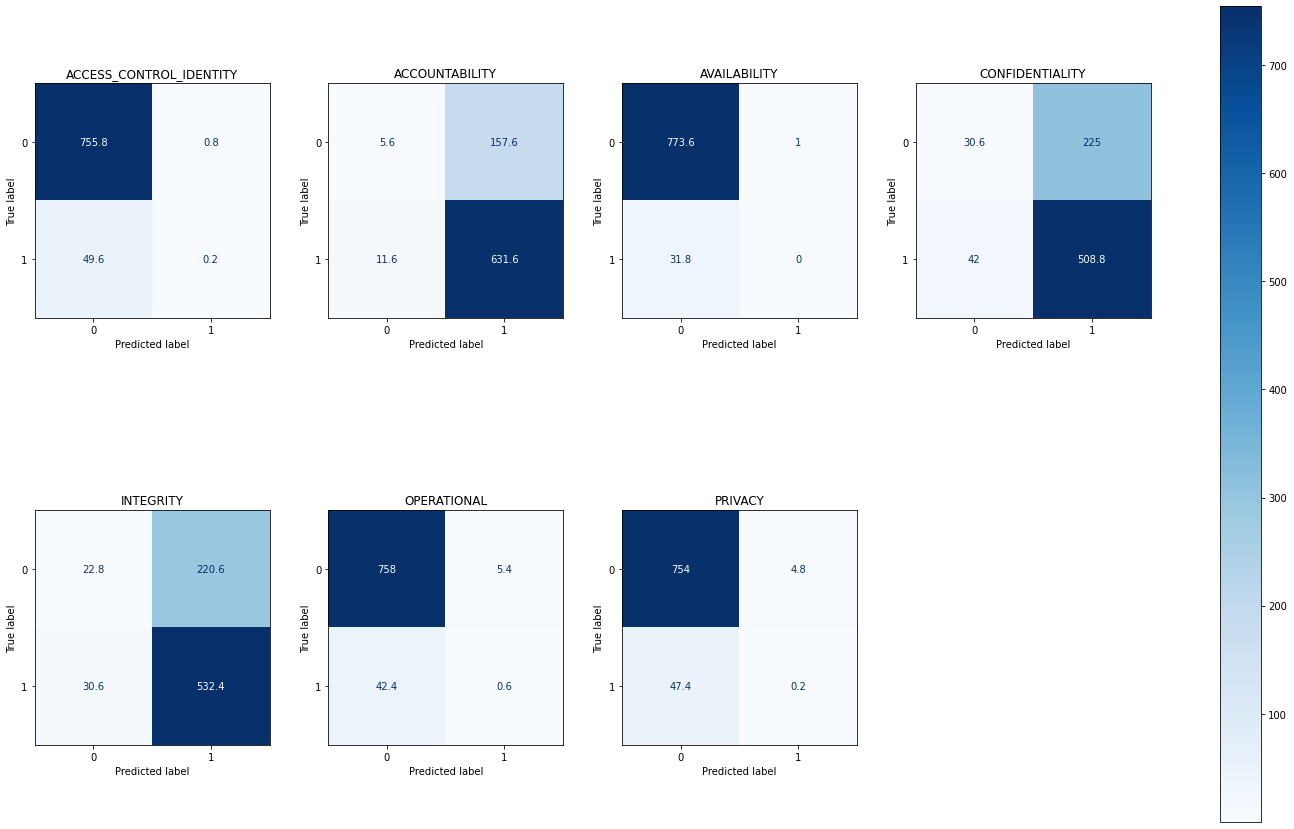

In [39]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5949328280944781
Precision: 0.6263828090918577
Recall Score: 0.7650470541652756
F1 Score: 0.6886096907196363
Hamming Loss: 0.236535946764991


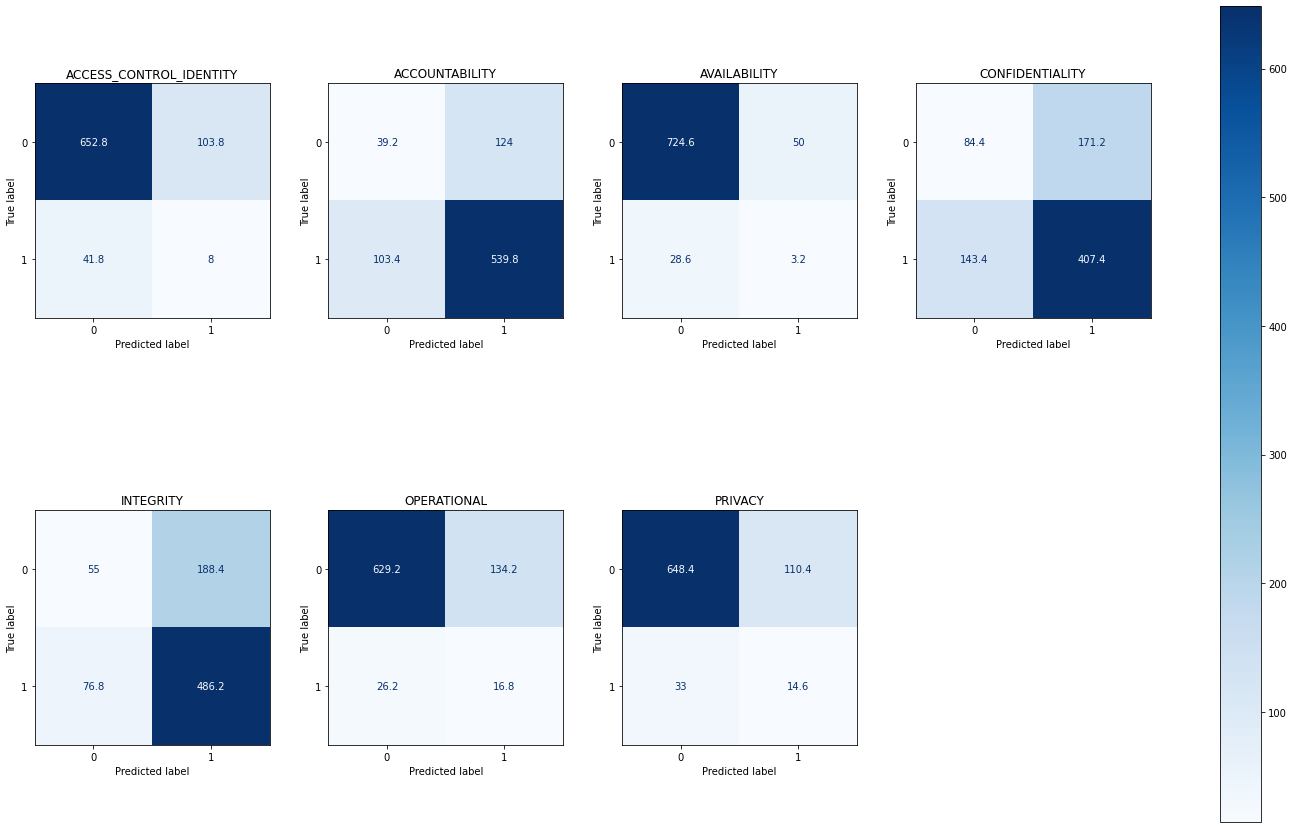

In [40]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6722316312087268
Precision: 0.7451799898704314
Recall Score: 0.8371102031608562
F1 Score: 0.7884633212890059
Hamming Loss: 0.15348578351336475


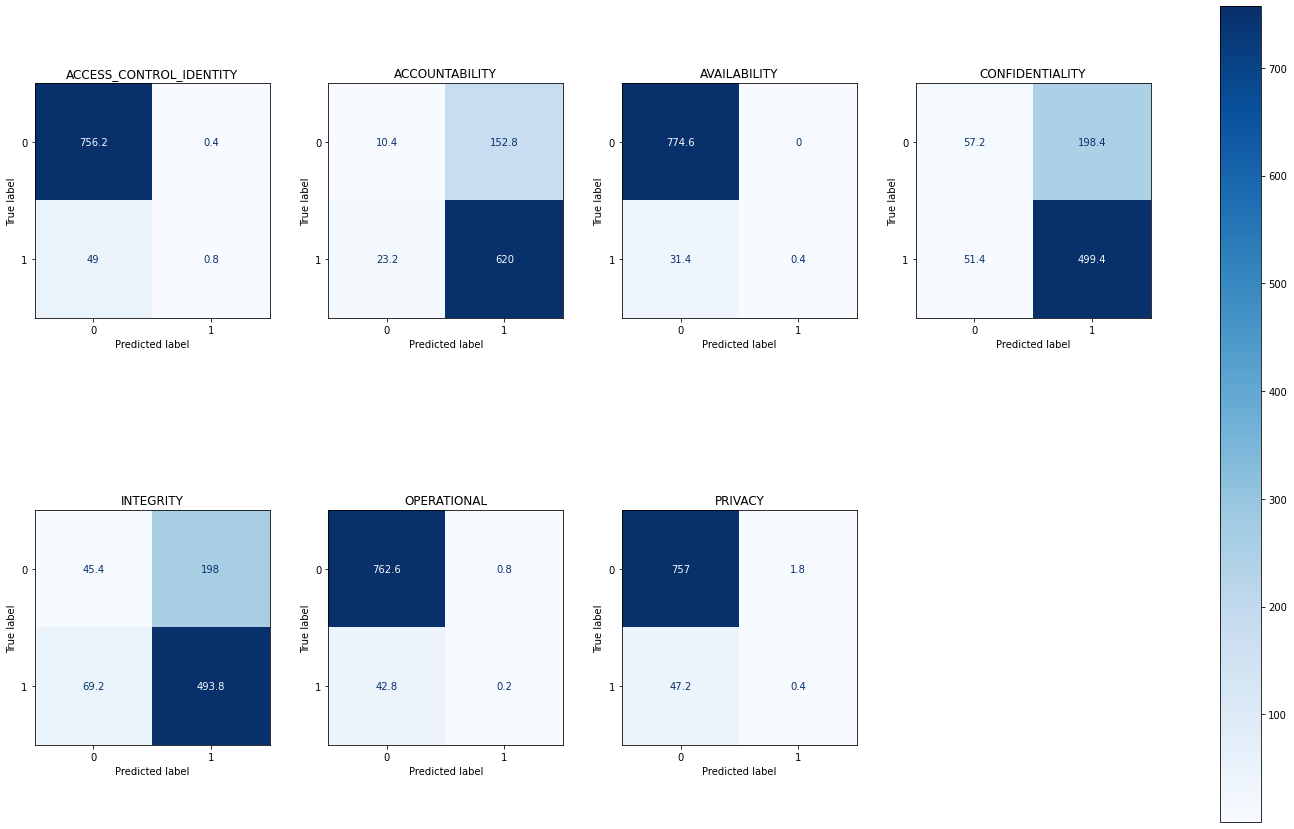

In [41]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.686356749205412
Precision: 0.7360334504226729
Recall Score: 0.8679827571202555
F1 Score: 0.7964389446874882
Hamming Loss: 0.15157402856167695


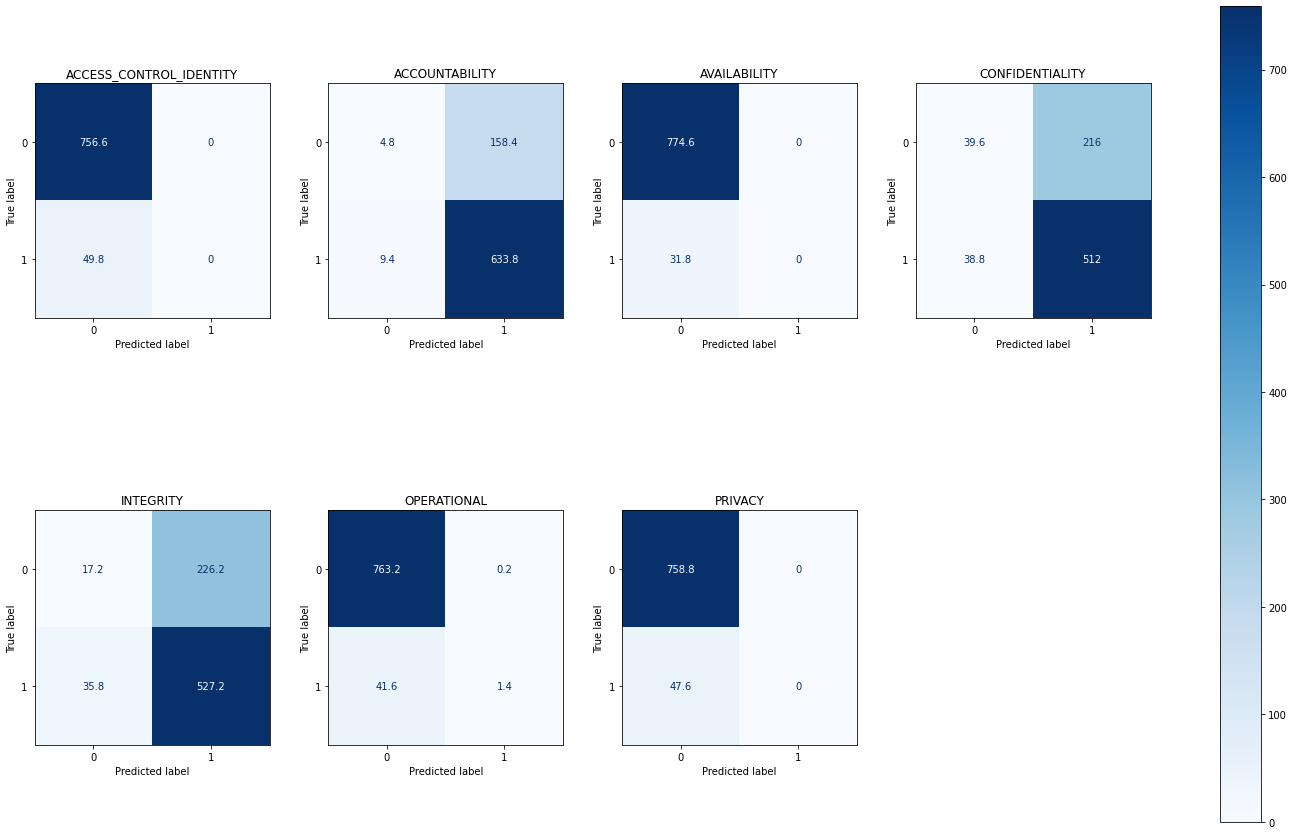

In [42]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7064738439399669
Precision: 0.7271561373842185
Recall Score: 0.9109118160209159
F1 Score: 0.8086856328793385
Hamming Loss: 0.14725024346082027


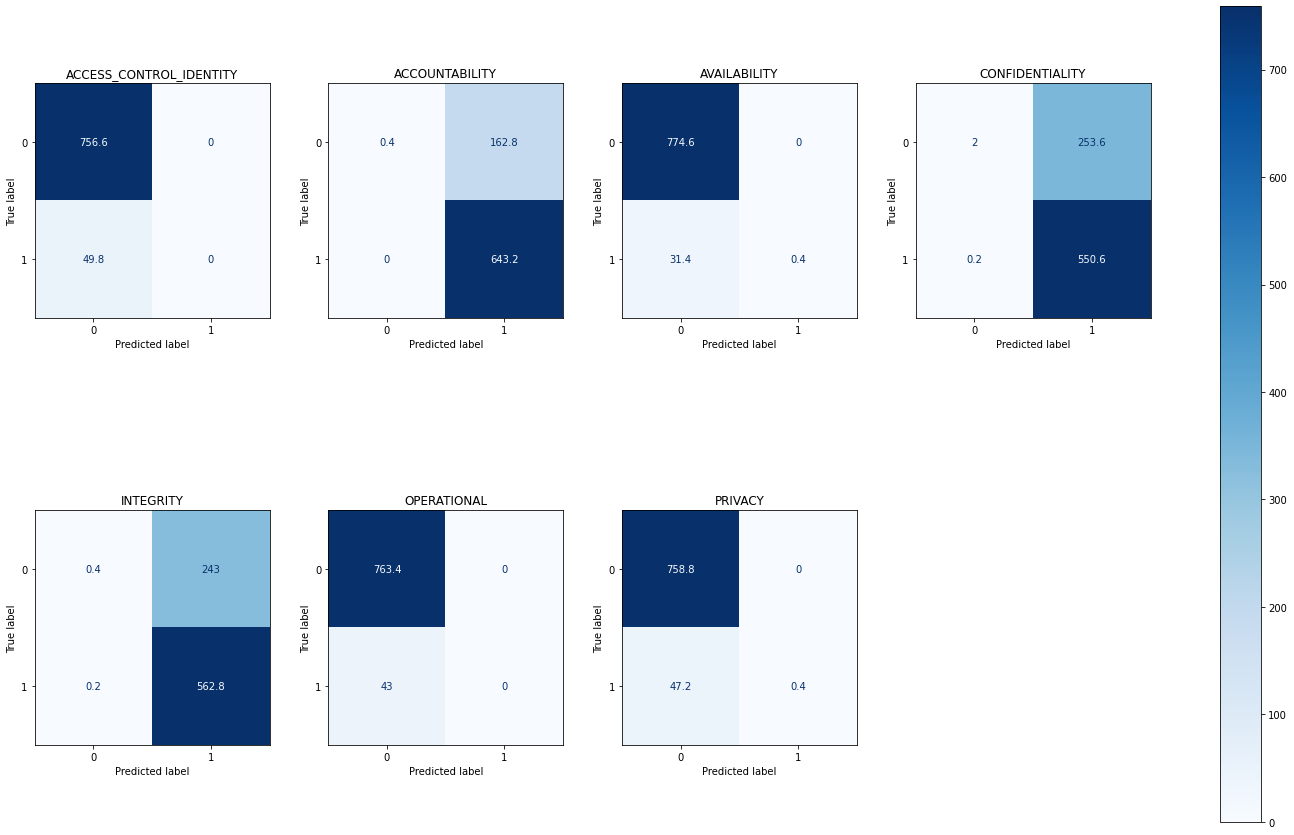

In [43]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.2) ClassifierChain**

####2.4.2.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6959977625471089
Precision: 0.7445230970247463
Recall Score: 0.8697076885714058
F1 Score: 0.8022133345436183
Hamming Loss: 0.1465423292380961


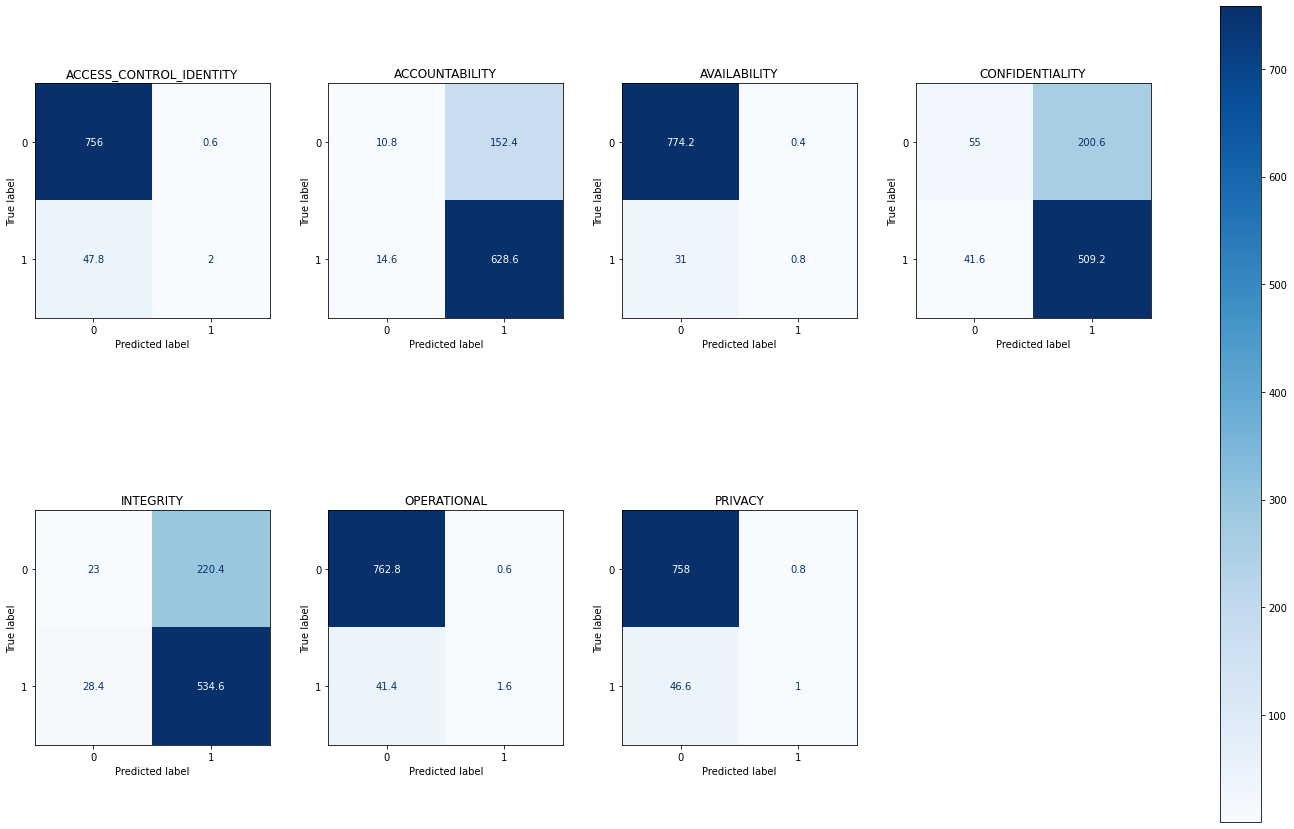

In [44]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6858422631584881
Precision: 0.7326801076628146
Recall Score: 0.8713458512276869
F1 Score: 0.7959872396473687
Hamming Loss: 0.15263581204341486


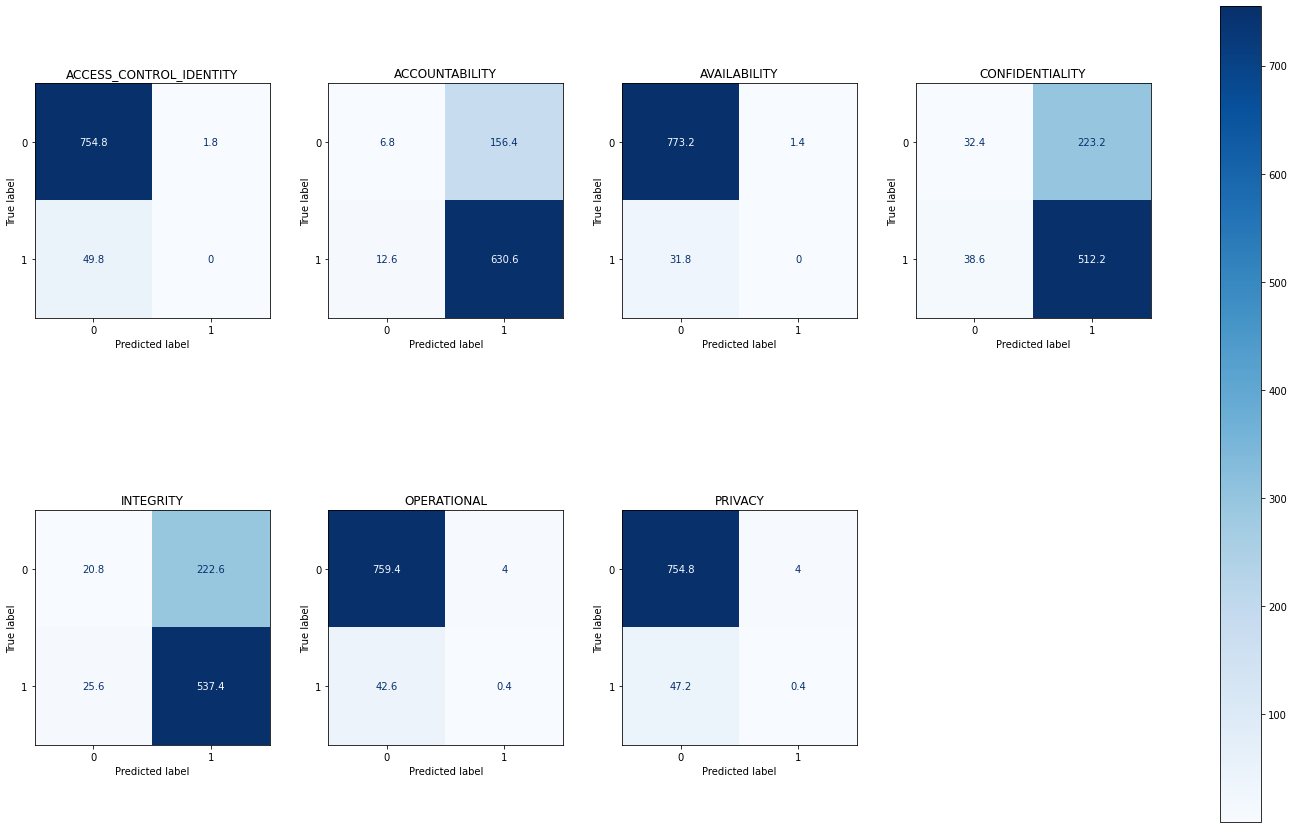

In [45]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5944726662792379
Precision: 0.6273262155270329
Recall Score: 0.7674213116566256
F1 Score: 0.690288713261308
Hamming Loss: 0.2353012698617687


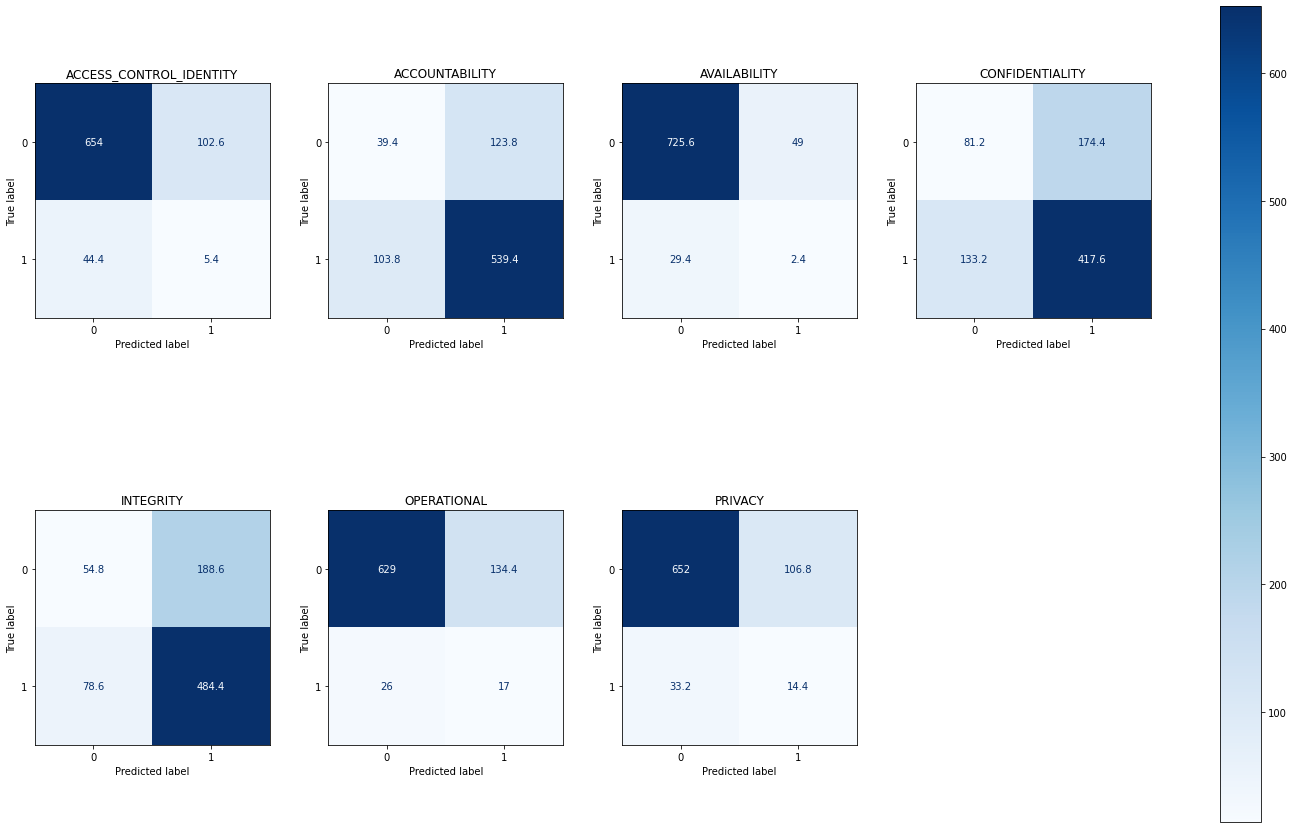

In [46]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6744163404782184
Precision: 0.7483348528172572
Recall Score: 0.8390983970941855
F1 Score: 0.7910774257345901
Hamming Loss: 0.1514693964148335


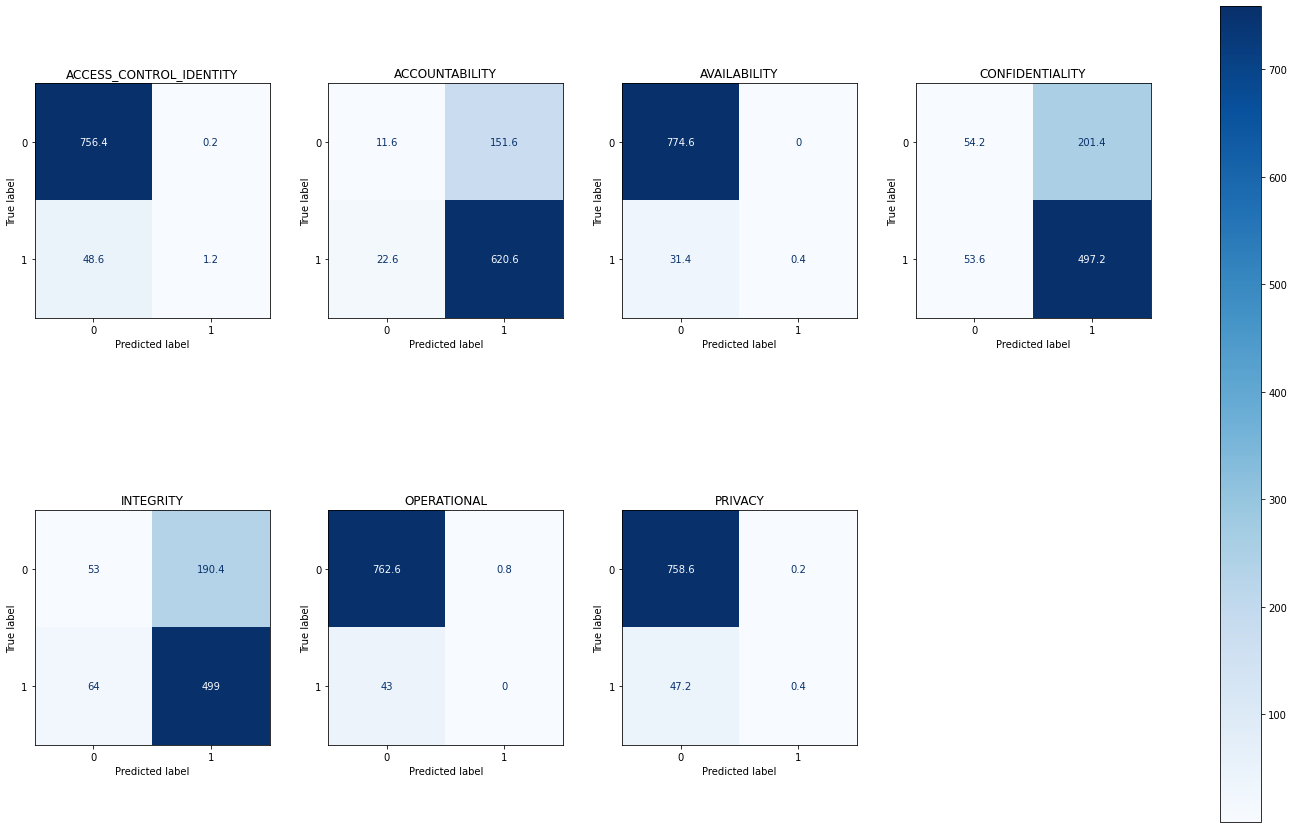

In [47]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6898662960468933
Precision: 0.7353819243694125
Recall Score: 0.8759305316301838
F1 Score: 0.7993706480925682
Hamming Loss: 0.15022817451166173


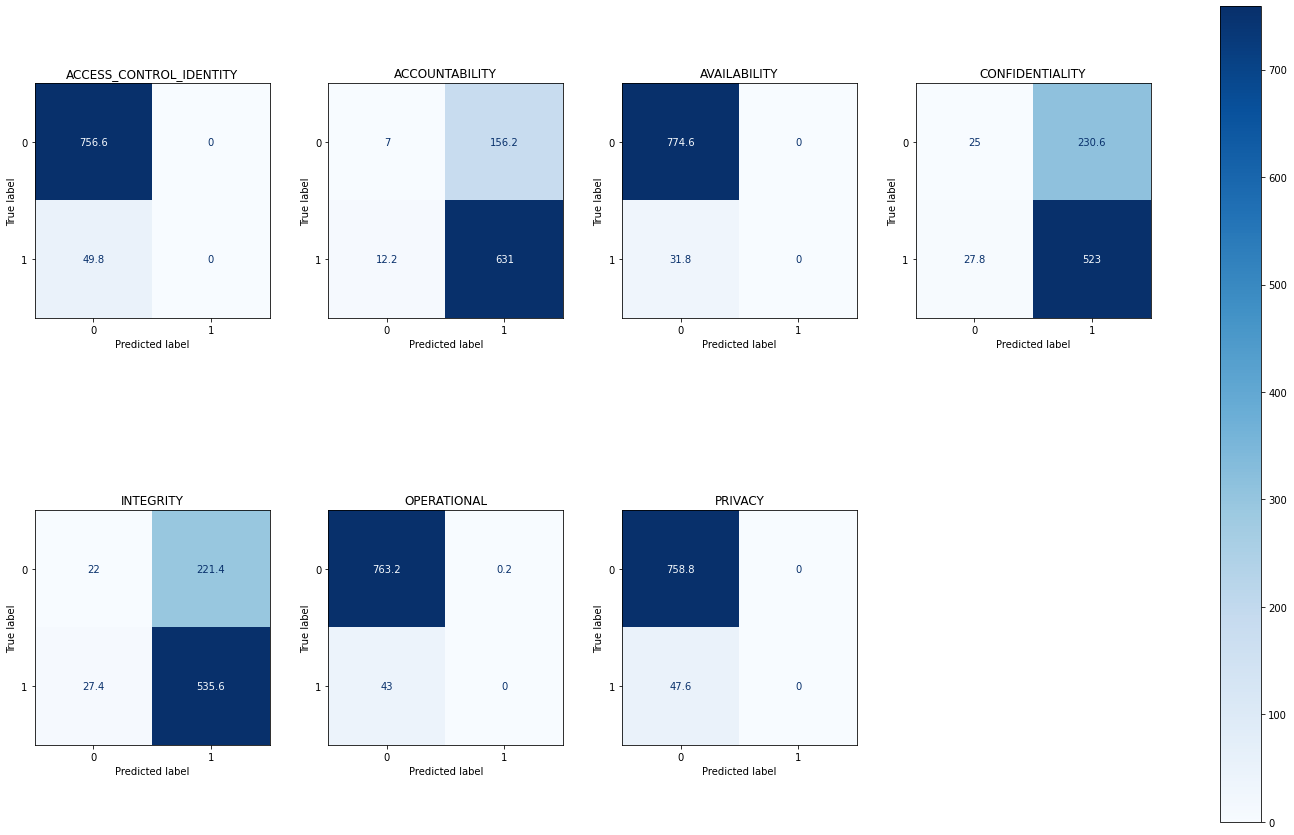

In [48]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7063055327505501
Precision: 0.7271383171585939
Recall Score: 0.9108374188824572
F1 Score: 0.8086635008424115
Hamming Loss: 0.14728714144711266


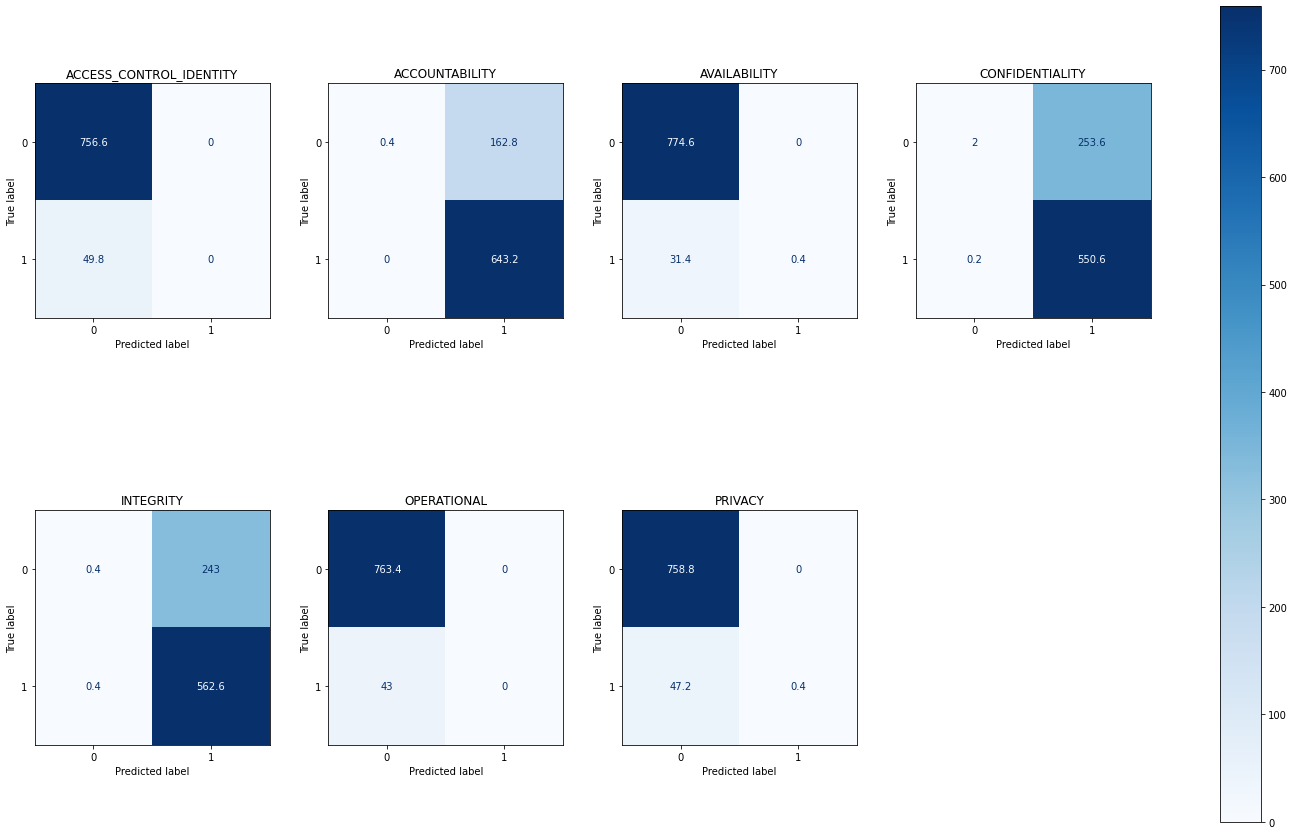

In [49]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.3) LabelPowerset**

####2.4.3.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.701371636517937
Precision: 0.7508559644141816
Recall Score: 0.8682275046348582
F1 Score: 0.8052821728591795
Hamming Loss: 0.14349451164416988


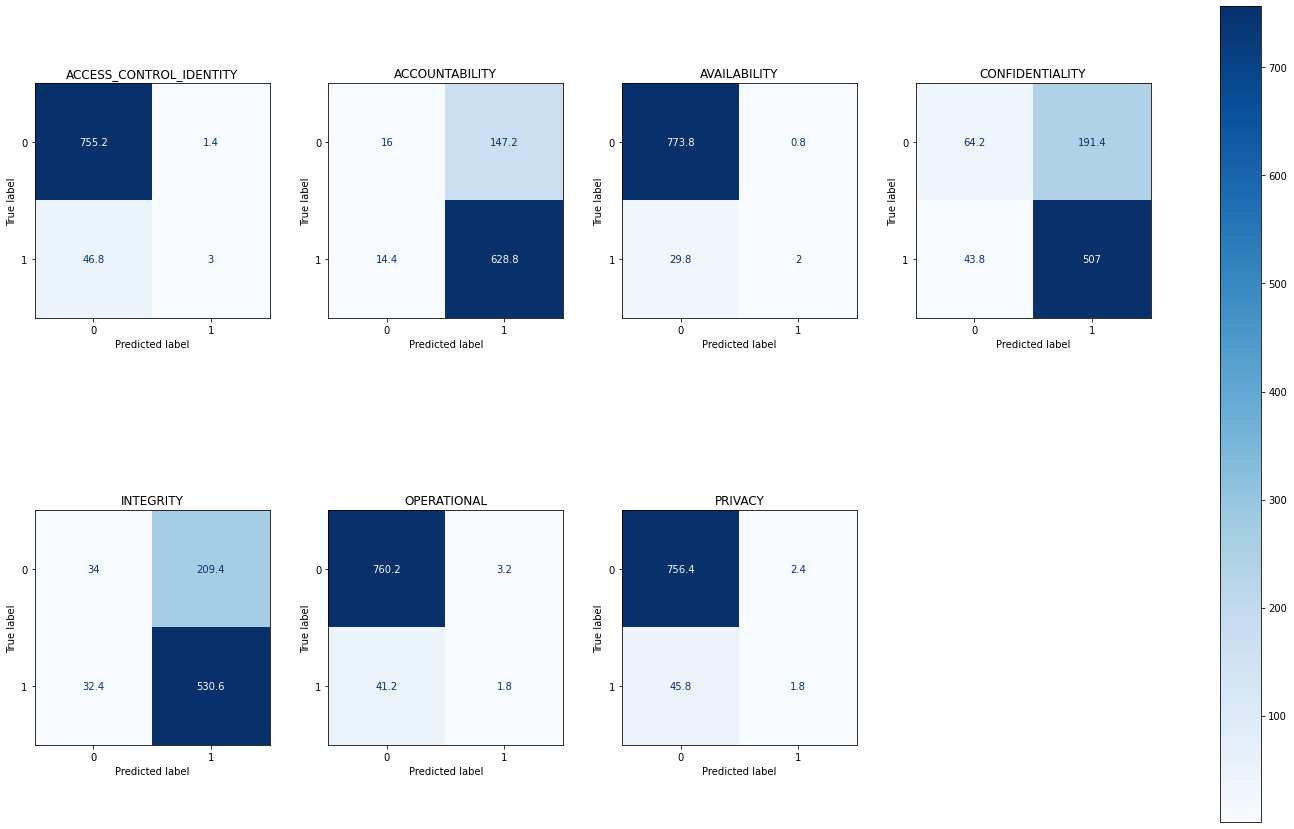

In [50]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6830200796791516
Precision: 0.7279324040524653
Recall Score: 0.8696985259072882
F1 Score: 0.792499771026176
Hamming Loss: 0.15564927936914988


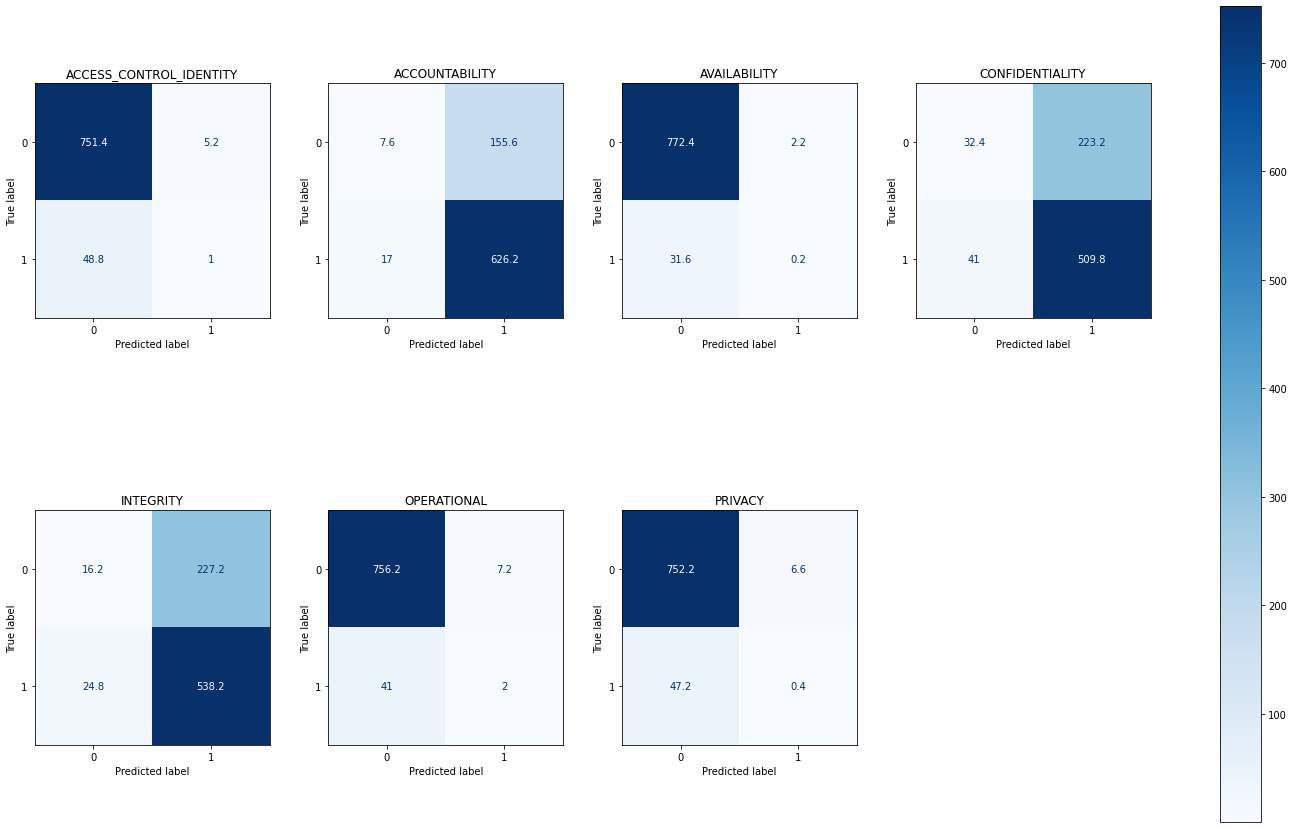

In [51]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5966224139746145
Precision: 0.6288860802848386
Recall Score: 0.7669219645754449
F1 Score: 0.6910330351455224
Hamming Loss: 0.23433924272154277


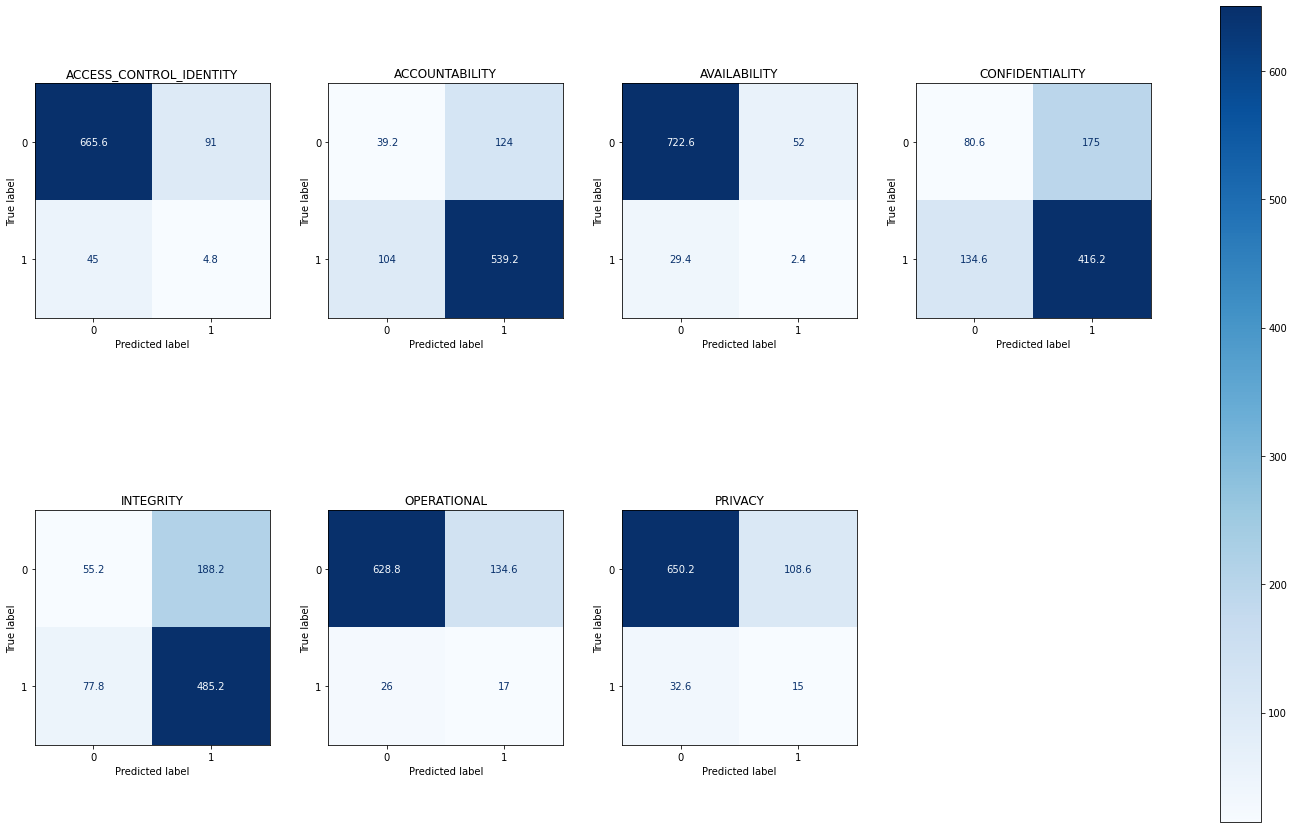

In [52]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6824279541194038
Precision: 0.7355697742789017
Recall Score: 0.8565551793280415
F1 Score: 0.7913628191928307
Hamming Loss: 0.15433698491619108


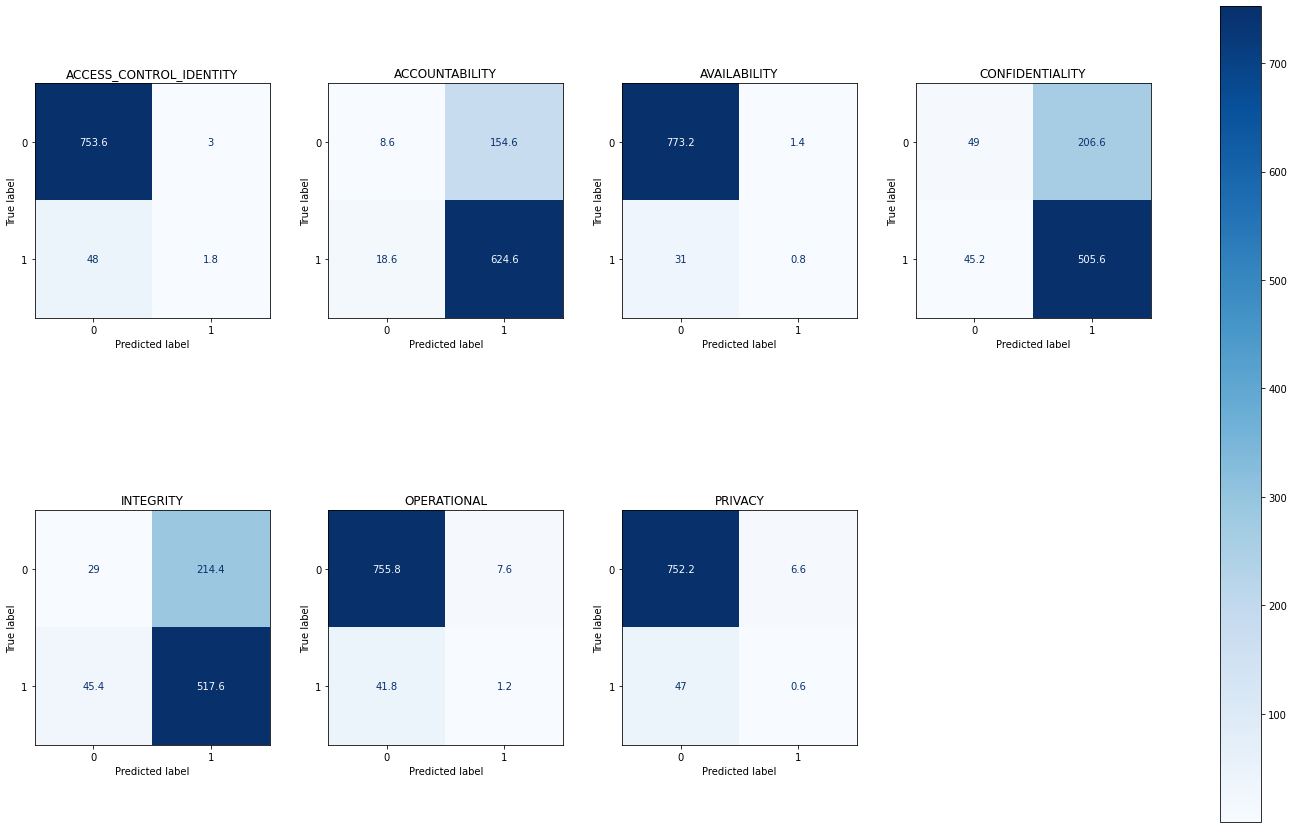

In [53]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7023148259183755
Precision: 0.7300415588744166
Recall Score: 0.8993466641824245
F1 Score: 0.8058218605085429
Hamming Loss: 0.1480683684545059


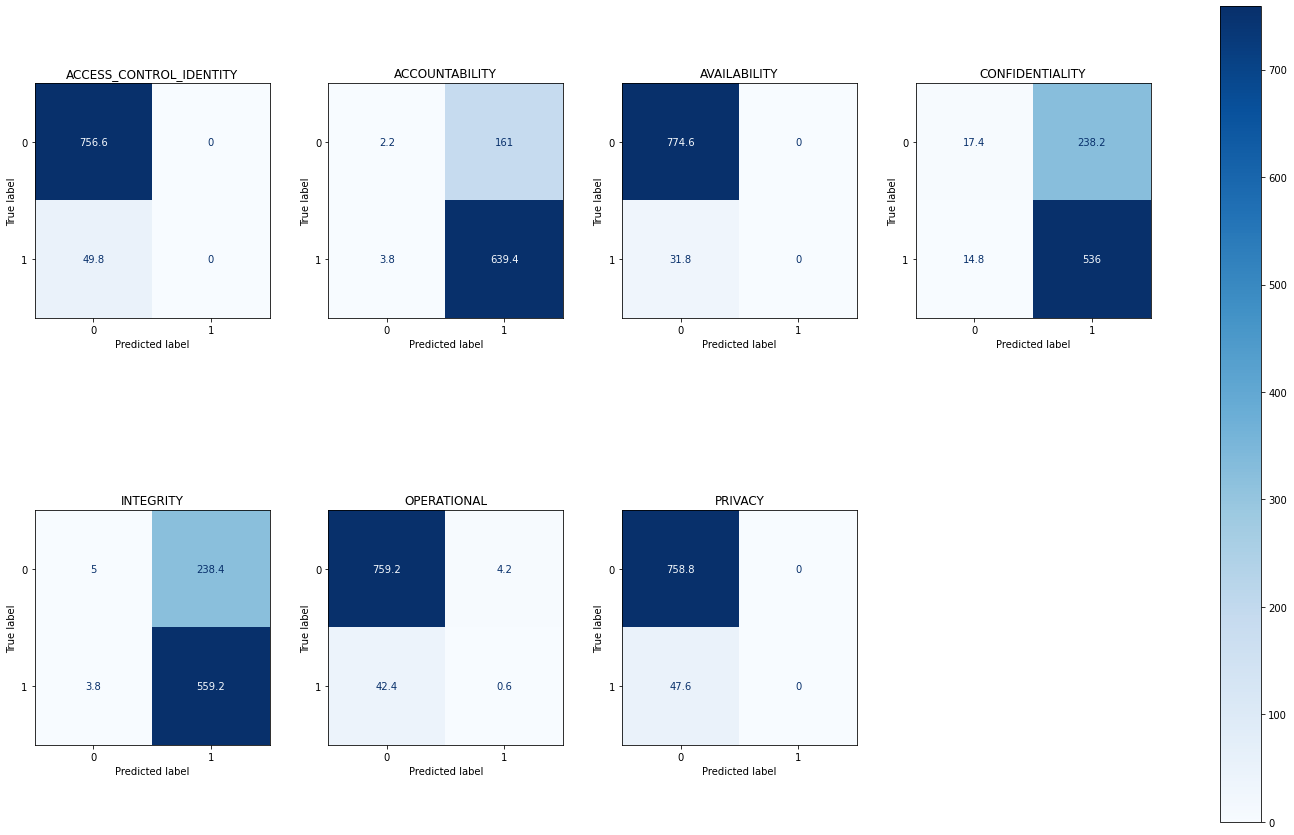

In [54]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7064739105613311
Precision: 0.7272568720399557
Recall Score: 0.910863228099703
F1 Score: 0.808764204532984
Hamming Loss: 0.14721470718592675


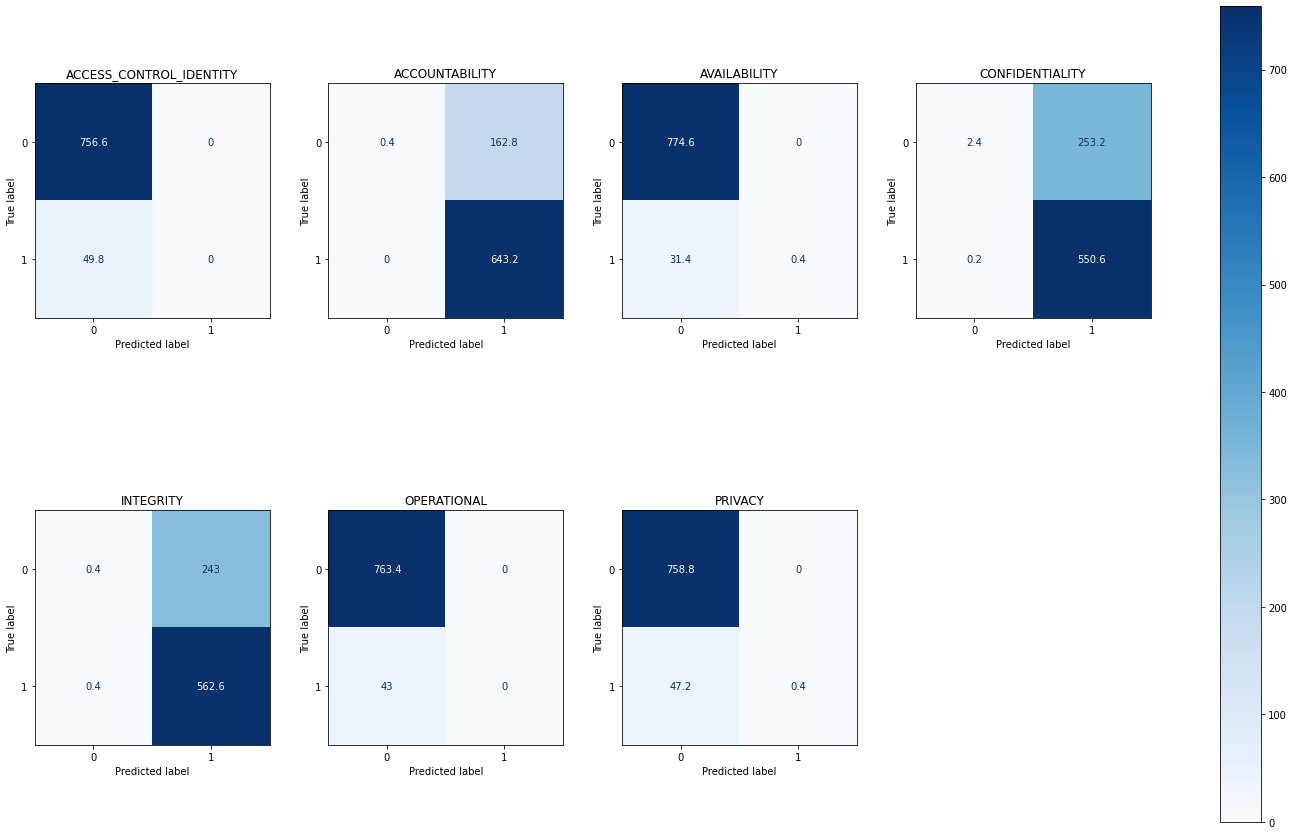

In [55]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

#2.5) Analisi keywords


In [ ]:
bow = ""
for lists in cat_df["Security Words"]:
  if lists != 'none':
    lists = ast.literal_eval(lists)
    for words in lists:
        bow += words + " "

bow

'access access access client privacy access internet share privacy access data custodian access privacy access data custodian access access risk data integrity access access access access user access access response safety share client access access access access set set set set set capability access subject response set access access access access access access access information sharing safety access user interoperability set alert consequence authentication signature interoperability identity identity identity set user identity identity identity identity interoperability interoperability authentication authenticate alert privacy authorization authorization sensitive information privacy authorization authorization event authorization user user response response protocol interoperability protocol user set set set identity filter filter filter filter user user authenticate event identity filter response user event signature access access user access response alert access response regis

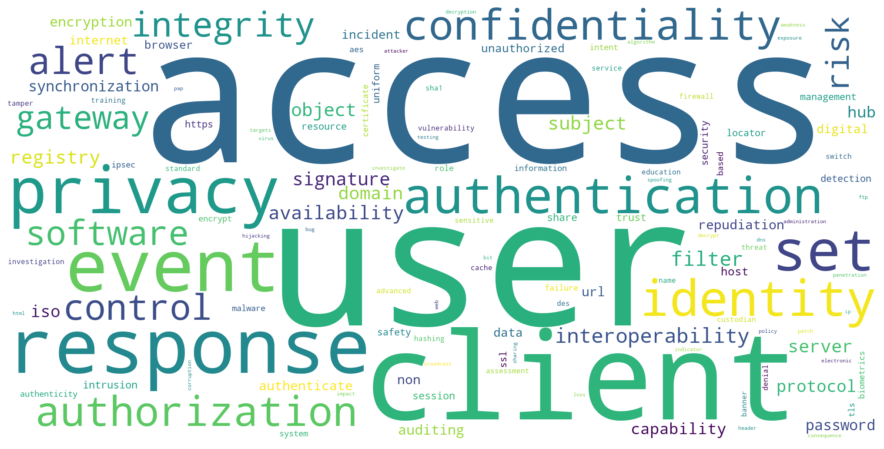

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 2000, height = 1000, collocations=False, background_color="white").generate(bow)

plt.figure(figsize=(32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
keywords_list = []

for i in range(0, len(cat_df)):
  keywords = cat_df.iloc[i]["Security Words"]
  if keywords != 'none': 
    keywords = ast.literal_eval(keywords)
    for word in keywords:
      if word not in keywords_list:
        keywords_list.append(word)
len(keywords_list)

117

In [ ]:
cats = ['ACCESS_CONTROL_IDENTITY',	'ACCOUNTABILITY',	'AVAILABILITY',	'CONFIDENTIALITY',	'INTEGRITY',	'OPERATIONAL',	'PRIVACY']
cats_dict = dict.fromkeys(cats, 0)
for key in cats_dict.keys():
  cats_dict[key] = dict.fromkeys(keywords_list, 0)
  

In [ ]:
for i in range(0, len(cat_df)):
  categories = cat_df.iloc[i]["Categories"]
  keywords = cat_df.iloc[i]["Security Words"]
  if keywords != 'none': 
    keywords = ast.literal_eval(keywords)
    for cat in categories:
      for kw in keywords:
          cats_dict[cat][kw] += 1

#cats_dict

In [ ]:
cat_occurr = dict.fromkeys(cats, 0)
for i in range(0, len(cat_df)):
  categories = cat_df.iloc[i]["Categories"]
  for cat in categories:
    cat_occurr[cat] += 1

#cat_occurr

{'ACCESS_CONTROL_IDENTITY': 249,
 'ACCOUNTABILITY': 3216,
 'AVAILABILITY': 159,
 'CONFIDENTIALITY': 2754,
 'INTEGRITY': 2815,
 'OPERATIONAL': 215,
 'PRIVACY': 238}

In [ ]:
for cat in cats_dict.keys():
  for kw in cats_dict[cat].keys():
    cats_dict[cat][kw] = (cats_dict[cat][kw] / cat_occurr[cat]) * 100
    
#cats_dict

In [ ]:
final_dic = dict.fromkeys(cats, 0)

for cat in cats_dict.keys():
  final_dic[cat] = {}
  for kw in cats_dict[cat].keys():
    if cats_dict[cat][kw] >= 2:
        final_dic[cat][kw] = cats_dict[cat][kw]

for cat in final_dic.keys():
  sort_orders = sorted(final_dic[cat].items(), key=lambda x: x[1], reverse=True)
  print("Keywords associate alla categoria " + cat + ":")
  if(sort_orders):
    for item in sort_orders:
      print("\t" + item[0] + ": " + str(item[1]))
  else:
      print("\tNessuna")
  print("\n")

Keywords associate alla categoria ACCESS_CONTROL_IDENTITY:
	user: 17.269076305220885
	authentication: 14.056224899598394
	access: 8.433734939759036
	identity: 6.827309236947792
	password: 3.614457831325301
	authenticate: 2.8112449799196786


Keywords associate alla categoria ACCOUNTABILITY:
	user: 5.814676616915423
	access: 5.317164179104478
	client: 3.3893034825870645
	response: 2.4875621890547266
	event: 2.1144278606965177


Keywords associate alla categoria AVAILABILITY:
	access: 11.320754716981133
	availability: 7.547169811320755
	user: 4.40251572327044
	server: 3.7735849056603774
	integrity: 3.1446540880503147
	confidentiality: 3.1446540880503147


Keywords associate alla categoria CONFIDENTIALITY:
	access: 7.080610021786492
	user: 6.027596223674655
	client: 3.159041394335512
	response: 2.6143790849673203
	event: 2.4691358024691357


Keywords associate alla categoria INTEGRITY:
	user: 4.760213143872114
	client: 3.4813499111900534
	access: 2.6287744227353462
	response: 2.4156305506